In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from math import sqrt


In [2]:

#calculate auprc 95% ci for each model
def auroc_ci(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    mean = roc_auc
    std = sqrt(roc_auc * (1.0 - roc_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high

def auprc_ci(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    mean = pr_auc
    std = sqrt(pr_auc * (1.0 - pr_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high


In [3]:

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV


2023-10-23 14:17:36.186258: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 14:17:36.238918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 14:17:36.239912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 14:17:37.042762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data = pd.read_csv('../data/crc_folfox_mut_cna_fus_clin.csv', index_col=0)
data.head()

import datetime
today = datetime.date.today()
today_str = today.strftime('%m%d%y')
hp_date = '102123'


In [5]:
drug = 'folfox'
outcome = 'OS'
data_type = 'nonclin'
lasso_c = 2

In [6]:
data = pd.read_csv('../data/crc_{}_mut_cna_fus_clin.csv'.format(drug))
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
data = data.dropna(subset=[outcome])
data.reset_index(inplace=True, drop=True)


In [7]:
hp_res = {}
for i in range(0, 5):
    hp_res[i] = pd.read_csv(f'../results/hp_search/results_rf_lasso_folfox_OS_nonclin_102123_{i}.csv', index_col=0)
    hp_res[i] = hp_res[i].set_index('rank_test_score')
hp_res[0].head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,
1,0.994540,0.019745,0.058249,0.000469,True,20.0,auto,2,3,500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.636713,0.635597,0.691593,0.553385,0.584522,0.620362,0.047631
2,2.978256,0.059524,0.163261,0.002586,True,20.0,auto,2,3,1500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.626944,0.644536,0.695309,0.544646,0.587836,0.619854,0.051057
3,2.962767,0.044227,0.165105,0.009035,True,20.0,auto,2,3,1500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.645185,0.634291,0.694204,0.543039,0.579500,0.619244,0.052736
4,3.069146,0.080060,0.163870,0.006142,True,20.0,auto,2,3,1500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.627343,0.644235,0.696213,0.551075,0.576386,0.619050,0.051182
5,3.159334,0.075160,0.168840,0.014801,True,20.0,auto,2,3,1500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.623256,0.643230,0.698624,0.544446,0.582814,0.618474,0.052558


In [8]:
hp_res[0]['param_n_estimators'][1]

500

In [9]:
def make_rf_model(fold):
    n_estimators = hp_res[fold]['param_n_estimators'][1]
    n_estimators = int(n_estimators)
    max_depth = hp_res[fold]['param_max_depth'][1]
    max_depth = int(max_depth)
    min_samples_split = hp_res[fold]['param_min_samples_split'][1]
    min_samples_split = int(min_samples_split)
    min_samples_leaf = hp_res[fold]['param_min_samples_leaf'][1]
    min_samples_leaf = int(min_samples_leaf)
    max_features = hp_res[fold]['param_max_features'][1]
    bootstrap = hp_res[fold]['param_bootstrap'][1]
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        max_features=max_features,
                                        bootstrap=bootstrap,
                                        random_state=42)
    return rf_model
rf = make_rf_model(0)


In [10]:
data['rf_preds'] = np.NaN
data.head()

,id,id_institution,id_drugs_list,OS,id_tt_os_g_mos,PFS,id_tt_pfs_m_g_mos,mut_CDK4,mut_CCND3,mut_CDH1,...,clin_ca_crc_td,clin_ca_crc_crm,clin_ca_crc_peri_inv,clin_crc_type,OS_time,clin_Histology Category,clin_Histology,clin_Derived Grade or Differentiation of Tumor,clin_CEA,rf_preds
0,GENIE-DFCI-000233,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,100.986842,0.0,31.578947,0,0,0,...,2,2,0,2,3303,0,0,1,1.0,NaN
1,GENIE-DFCI-000247,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",1,35.789474,0.0,3.914474,0,0,0,...,2,0,0,2,1163,0,0,0,4.9,NaN
2,GENIE-DFCI-000306,DFCI,"bev, Fluorouracil, Leucovorin Calcium, Oxalipl...",0,38.125000,0.0,12.960526,0,0,0,...,2,2,0,3,1230,0,0,1,0.7,NaN
3,GENIE-DFCI-000738,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,51.578947,NaN,NaN,0,0,0,...,0,2,0,3,1623,0,1,1,1.8,NaN
4,GENIE-DFCI-000924,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,65.361842,NaN,NaN,0,0,0,...,0,2,1,0,2039,0,0,1,0.6,NaN


In [11]:
#create 5 train, test splits, within each train, create 5 train, valid splits
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
groups = data['id']
X = data[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]
y = data[outcome]

res_df = pd.DataFrame(columns=['fold', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auprc_mean'])
fold_count = 0
for train_index, test_index in skf.split(X, y, groups):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    if (data_type != 'comb') & (data_type != 'nonclin'):
        X_train = X_train[[col for col in data.columns if '{}_'.format(data_type) in col]]
        X_test = X_test[[col for col in data.columns if '{}_'.format(data_type) in col]]
    elif data_type == 'nonclin':
        X_train = X_train[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'fus' in col]]
        X_test = X_test[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'fus' in col]]
    else:
        X_train = X_train[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]
        X_test = X_test[[col for col in data.columns if 'mut_' in col or 'cna_' in col or 'clin_' in col or 'fus' in col]]

    #use lasso to select features
    lasso = LogisticRegression(penalty='l1', C=lasso_c, solver='liblinear')
    lasso.fit(X_train, y_train)
    lasso_coef = lasso.coef_
    lasso_coef = lasso_coef[0]
    lasso_coef = pd.DataFrame({'feature': X_train.columns, 'coef': lasso_coef})
    lasso_coef = lasso_coef[lasso_coef['coef'] != 0]
    X_train = X_train[lasso_coef['feature']]
    X_test = X_test[lasso_coef['feature']]
    
    #print the number of mut_, cna_, and fus_ features selected
    print('fold {}'.format(fold_count))
    print('mut: {}'.format(len([col for col in X_train.columns if 'mut_' in col])))
    print('cna: {}'.format(len([col for col in X_train.columns if 'cna_' in col])))
    print('fus: {}'.format(len([col for col in X_train.columns if 'fus_' in col])))
    

    rf = make_rf_model(fold_count)
    rf.fit(X_train, y_train)

    preds = rf.predict_proba(X_train)[:,1]
    data.loc[train_index, 'rf_preds'] = preds


fold 0
mut: 140
cna: 126
fus: 24


/home/kchen/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


fold 0
mut: 131
cna: 125
fus: 25


/home/kchen/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


fold 0
mut: 134
cna: 130
fus: 26


/home/kchen/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


fold 0
mut: 146
cna: 124
fus: 23


/home/kchen/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


fold 0
mut: 134
cna: 128
fus: 17


/home/kchen/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [12]:
#get the number of clin_, mut_, cna_, and fus features used
clin_feats = [col for col in data.columns if 'clin_' in col]
mut_feats = [col for col in data.columns if 'mut_' in col]
cna_feats = [col for col in data.columns if 'cna_' in col]
fus_feats = [col for col in data.columns if 'fus' in col]
print('clin_feats: {}, mut_feats: {}, cna_feats: {}, fus_feats: {}'.format(len(clin_feats), len(mut_feats), len(cna_feats), len(fus_feats)))
print('total feats: {}'.format(len(clin_feats) + len(mut_feats) + len(cna_feats) + len(fus_feats)))

clin_feats: 21, mut_feats: 224, cna_feats: 224, fus_feats: 256
total feats: 725


In [13]:
data['rf_preds'].head()

0    0.327547
1    0.448250
2    0.211120
3    0.269246
4    0.322148
Name: rf_preds, dtype: float64

In [14]:
data.head()

,id,id_institution,id_drugs_list,OS,id_tt_os_g_mos,PFS,id_tt_pfs_m_g_mos,mut_CDK4,mut_CCND3,mut_CDH1,...,clin_ca_crc_td,clin_ca_crc_crm,clin_ca_crc_peri_inv,clin_crc_type,OS_time,clin_Histology Category,clin_Histology,clin_Derived Grade or Differentiation of Tumor,clin_CEA,rf_preds
0,GENIE-DFCI-000233,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,100.986842,0.0,31.578947,0,0,0,...,2,2,0,2,3303,0,0,1,1.0,0.327547
1,GENIE-DFCI-000247,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",1,35.789474,0.0,3.914474,0,0,0,...,2,0,0,2,1163,0,0,0,4.9,0.448250
2,GENIE-DFCI-000306,DFCI,"bev, Fluorouracil, Leucovorin Calcium, Oxalipl...",0,38.125000,0.0,12.960526,0,0,0,...,2,2,0,3,1230,0,0,1,0.7,0.211120
3,GENIE-DFCI-000738,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,51.578947,NaN,NaN,0,0,0,...,0,2,0,3,1623,0,1,1,1.8,0.269246
4,GENIE-DFCI-000924,DFCI,"Fluorouracil, Leucovorin Calcium, Oxaliplatin",0,65.361842,NaN,NaN,0,0,0,...,0,2,1,0,2039,0,0,1,0.6,0.322148


In [11]:
data_clin = data[[col for col in data.columns if 'clin_' in col]]
data_clin.head()

,clin_race_ethnicity,clin_naaccr_sex_code,clin_n_cpt_pt,clin_age_dx,clin_ca_grade,clin_institution,clin_stage_dx,clin_stage_dx_iv,clin_ca_path_group_stage,clin_ca_path_t_stage,...,clin_ca_tx_pre_path_stage,clin_ca_first_dmets1,clin_ca_crc_td,clin_ca_crc_crm,clin_ca_crc_peri_inv,clin_crc_type,clin_Histology Category,clin_Histology,clin_Derived Grade or Differentiation of Tumor,clin_CEA
0,3,0,0,47.0,1,0,3,0,2,2,...,1,5,2,2,0,2,0,0,1,1.0
1,3,0,0,63.0,0,0,4,1,6,7,...,0,0,2,0,0,2,0,0,0,4.9
2,3,0,0,55.0,1,0,4,1,6,7,...,0,1,2,2,0,3,0,0,1,0.7
3,2,0,0,48.0,1,0,3,0,6,7,...,0,5,0,2,0,3,0,1,1,1.8
4,3,0,0,44.0,1,0,3,0,6,7,...,0,5,0,2,1,0,0,0,1,0.6


In [12]:
data_clin.columns

Index(['clin_race_ethnicity', 'clin_naaccr_sex_code', 'clin_n_cpt_pt',
       'clin_age_dx', 'clin_ca_grade', 'clin_institution', 'clin_stage_dx',
       'clin_stage_dx_iv', 'clin_ca_path_group_stage', 'clin_ca_path_t_stage',
       'clin_ca_path_n_stage', 'clin_ca_tx_pre_path_stage',
       'clin_ca_first_dmets1', 'clin_ca_crc_td', 'clin_ca_crc_crm',
       'clin_ca_crc_peri_inv', 'clin_crc_type', 'clin_Histology Category',
       'clin_Histology', 'clin_Derived Grade or Differentiation of Tumor',
       'clin_CEA'],
      dtype='object')

In [13]:
#check for correlation between clinical features
corr_df = data_clin.corr()
#find pairs of features with correlation > 0.5
corr_df = corr_df.abs()
corr_df = corr_df.unstack()
corr_df = corr_df.sort_values(ascending=False)
corr_df = corr_df[corr_df < 1]
corr_df = pd.DataFrame(corr_df).reset_index()
corr_df.columns = ['feature1', 'feature2', 'corr']
corr_df.head(20)

,feature1,feature2,corr
0,clin_Histology Category,clin_Histology,0.912022
1,clin_Histology,clin_Histology Category,0.912022
2,clin_stage_dx_iv,clin_ca_first_dmets1,0.893963
3,clin_ca_first_dmets1,clin_stage_dx_iv,0.893963
4,clin_ca_path_t_stage,clin_ca_path_n_stage,0.888954
5,clin_ca_path_n_stage,clin_ca_path_t_stage,0.888954
6,clin_ca_path_group_stage,clin_ca_path_n_stage,0.866093
7,clin_ca_path_n_stage,clin_ca_path_group_stage,0.866093
8,clin_stage_dx_iv,clin_stage_dx,0.792563
9,clin_stage_dx,clin_stage_dx_iv,0.792563


In [21]:
clin_cols = [col for col in data.columns if 'clin_' in col]
drop = ['clin_Histology', 'clin_stage_dx_iv', 'clin_ca_first_dmets1', 'clin_ca_path_t_stage', 'clin_ca_path_n_stage', 'clin_ca_path_group_stage', 'clin_Derived Grade or Differentiation of Tumor']
clin_cols = [col for col in clin_cols if col not in drop]
#add rf preds to clin data
clin_cols.append('rf_preds')
#add outcome to clin data
clin_cols.append(outcome)
data_lr = data[clin_cols]
data_lr.head()

,clin_race_ethnicity,clin_naaccr_sex_code,clin_n_cpt_pt,clin_age_dx,clin_ca_grade,clin_institution,clin_stage_dx,clin_ca_tx_pre_path_stage,clin_ca_crc_td,clin_ca_crc_crm,clin_ca_crc_peri_inv,clin_crc_type,clin_Histology Category,clin_CEA,rf_preds,OS
0,3,0,0,47.0,1,0,3,1,2,2,0,2,0,1.0,0.324404,0
1,3,0,0,63.0,0,0,4,0,2,0,0,2,0,4.9,0.450795,1
2,3,0,0,55.0,1,0,4,0,2,2,0,3,0,0.7,0.221266,0
3,2,0,0,48.0,1,0,3,0,0,2,0,3,0,1.8,0.270789,0
4,3,0,0,44.0,1,0,3,0,0,2,1,0,0,0.6,0.322209,0


In [22]:
#check for correlation between clinical features
corr_df = data_lr.corr()
#find pairs of features with correlation > 0.5
corr_df = corr_df.abs()
corr_df = corr_df.unstack()
corr_df = corr_df.sort_values(ascending=False)
corr_df = corr_df[corr_df < 1]
corr_df = pd.DataFrame(corr_df).reset_index()
corr_df.columns = ['feature1', 'feature2', 'corr']
corr_df.head(20)

,feature1,feature2,corr
0,OS,rf_preds,0.682459
1,rf_preds,OS,0.682459
2,clin_ca_crc_td,clin_ca_crc_crm,0.479167
3,clin_ca_crc_crm,clin_ca_crc_td,0.479167
4,clin_ca_crc_crm,clin_ca_crc_peri_inv,0.309051
5,clin_ca_crc_peri_inv,clin_ca_crc_crm,0.309051
6,OS,clin_ca_crc_crm,0.298230
7,clin_ca_crc_crm,OS,0.298230
8,clin_CEA,clin_stage_dx,0.268999
9,clin_stage_dx,clin_CEA,0.268999


In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = data_lr[[col for col in data_lr.columns if col != outcome]]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

#sort by VIF
vif_data.sort_values(by='VIF', ascending=False, inplace=True)
vif_data

,feature,VIF
3,clin_age_dx,14.819868
6,clin_stage_dx,13.422771
0,clin_race_ethnicity,8.380089
14,rf_preds,8.255931
9,clin_ca_crc_crm,4.412847
4,clin_ca_grade,3.532824
8,clin_ca_crc_td,3.032290
11,clin_crc_type,2.875958
5,clin_institution,2.454217
1,clin_naaccr_sex_code,2.213365


In [24]:
#make a logistic regression model with all clinical features and the rf preds to determin if rf preds have a significant association with outcome
lr = sm.Logit(data_lr[outcome], data_lr[[col for col in data_lr.columns if col != outcome]])
#increase the iterations to 1000
lr_res = lr.fit(maxiter=1000)
lr_res.summary()

Optimization terminated successfully.
         Current function value: 0.373182
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     OS   No. Observations:                 1290
Model:                          Logit   Df Residuals:                     1275
Method:                           MLE   Df Model:                           14
Date:                Sun, 22 Oct 2023   Pseudo R-squ.:                  0.4275
Time:                        16:46:43   Log-Likelihood:                -481.40
converged:                       True   LL-Null:                       -840.93
Covariance Type:            nonrobust   LLR p-value:                2.202e-144
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
clin_race_ethnicity          -0.5236      0.077     -6.827      0.000      -0.674      -0.373
clin_naaccr_sex_code         -0.4097      0.163     -2.519      0.012      -0.729      -0.091
clin_n_cpt_pt                -0.0405      0.373     -0.108      0.914      -0.772       0.691
clin_age_dx                  -0.0373      0.006     -6.066      0.000      -0.049      -0.025
clin_ca_grade                -0.1143      0.078     -1.459      0.145      -0.268       0.039
clin_institution             -0.1954      0.130     -1.504      0.133      -0.450       0.059
clin_stage_dx                -0.2380      0.085     -2.797      0.005      -0.405      -0.071
clin_ca_tx_pre_path_stage    -0.6140      0.487     -1.261      0.207      -1.568       0.340
clin_ca_crc_td               -0.3737      0.113     -3.316      0.001      -0.595      -0.153
clin_ca_crc_crm              -0.9275      0.092    -10.070      0.000      -1.108      -0.747
clin_ca_crc_peri_inv          0.0011      0.189      0.006      0.995      -0.370       0.372
clin_crc_type                -0.1128      0.069     -1.642      0.101      -0.248       0.022
clin_Histology Category       0.0326      0.061      0.529      0.597      -0.088       0.153
clin_CEA                      0.0077      0.002      3.293      0.001       0.003       0.012
rf_preds                     17.0409      1.093     15.586      0.000      14.898      19.184
=============================================================================================
"""

In [26]:
#do the same thing with PFS instead of OS
outcome = 'PFS'
clin_cols = [col for col in data.columns if 'clin_' in col]
drop = ['clin_Histology', 'clin_stage_dx_iv', 'clin_ca_first_dmets1', 'clin_ca_path_t_stage', 'clin_ca_path_n_stage', 'clin_ca_path_group_stage', 'clin_Derived Grade or Differentiation of Tumor']
clin_cols = [col for col in clin_cols if col not in drop]
clin_cols.append('rf_preds')
clin_cols.append(outcome)
data_lr = data[clin_cols]


In [28]:
#drop rows with missing outcome
data_lr = data_lr.dropna(subset=[outcome])

In [29]:
#make a logistic regression model with all clinical features and the rf preds to determin if rf preds have a significant association with outcome
lr = sm.Logit(data_lr[outcome], data_lr[[col for col in data_lr.columns if col != outcome]])
#increase the iterations to 1000
lr_res = lr.fit(maxiter=1000)
lr_res.summary()

Optimization terminated successfully.
         Current function value: 0.561532
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    PFS   No. Observations:                  971
Model:                          Logit   Df Residuals:                      956
Method:                           MLE   Df Model:                           14
Date:                Sun, 22 Oct 2023   Pseudo R-squ.:                 0.03007
Time:                        16:47:48   Log-Likelihood:                -545.25
converged:                       True   LL-Null:                       -562.15
Covariance Type:            nonrobust   LLR p-value:                  0.002200
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
clin_race_ethnicity          -0.1355      0.070     -1.945      0.052      -0.272       0.001
clin_naaccr_sex_code         -0.3144      0.150     -2.091      0.037      -0.609      -0.020
clin_n_cpt_pt                -0.4316      0.438     -0.985      0.324      -1.290       0.427
clin_age_dx                  -0.0079      0.005     -1.531      0.126      -0.018       0.002
clin_ca_grade                -0.0516      0.068     -0.758      0.448      -0.185       0.082
clin_institution              0.2252      0.116      1.950      0.051      -0.001       0.452
clin_stage_dx                -0.2136      0.075     -2.833      0.005      -0.361      -0.066
clin_ca_tx_pre_path_stage     0.0742      0.427      0.174      0.862      -0.763       0.911
clin_ca_crc_td               -0.0351      0.102     -0.344      0.731      -0.235       0.165
clin_ca_crc_crm              -0.2024      0.079     -2.576      0.010      -0.356      -0.048
clin_ca_crc_peri_inv         -0.0325      0.179     -0.181      0.856      -0.383       0.318
clin_crc_type                 0.0621      0.064      0.973      0.331      -0.063       0.187
clin_Histology Category       0.0179      0.053      0.336      0.737      -0.086       0.122
clin_CEA                      0.0005      0.002      0.250      0.803      -0.003       0.004
rf_preds                      2.3332      0.516      4.526      0.000       1.323       3.344
=============================================================================================
"""

In [ ]:

    results = pd.DataFrame(rf.cv_results_)
    results.sort_values(by='rank_test_score').to_csv('../../results/hp_search/results_rf_lasso_{}_{}_{}_{}_{}.csv'.format(drug, outcome, data_type, today_str, fold_count))
    best_rf = rf.best_estimator_

    y_pred = best_rf.predict_proba(X_test)[:,1]
        
    test_auroc_mean = roc_auc_score(y_test, y_pred)
        
    test_auprc_mean = average_precision_score(y_test, y_pred)

    val_auroc = rf.best_score_
    val_auroc_mean = val_auroc
    val_auroc_std = str(val_auroc - results['std_test_score'][rf.best_index_]) + '-' + str(val_auroc + results['std_test_score'][rf.best_index_])
    val_auroc_ci = str(val_auroc - 2*results['std_test_score'][rf.best_index_]) + '-' + str(val_auroc + 2*results['std_test_score'][rf.best_index_])
    res_df.loc[fold_count] = [fold_count, val_auroc_mean, val_auroc_ci, test_auroc_mean, test_auprc_mean]

    del rf
    del best_rf

    fold_count += 1

out_folder = '../../results/lasso_runs/{}'.format(today_str)
#if out_folder does not exist, create it
if not os.path.exists(out_folder):
    os.mkdir(out_folder)
    res_df.to_csv('../../results/lasso_runs/{}/results_rf_{}_{}_{}_{}.csv'.format(today_str, drug, outcome, data_type, today_str))
else:
    res_df.to_csv('../../results/lasso_runs/{}/results_rf_{}_{}_{}_{}.csv'.format(today_str, drug, outcome, data_type, today_str))


In [2]:
train = pd.read_csv('../data/pdx/pdx_act_mut_cpr.csv')
train.head()

,line,act_AAK1,act_ABL1,act_ABL1_nonphosphorylated,act_ABL1_phosphorylated,act_ABL2,act_ACVR1,act_ACVR1B,act_ACVR2A,act_ACVR2B,...,mut_CDKN1A,mut_ROS1,mut_DAXX,mut_TSC2,mut_RAD51C,mut_ARID1A,mut_AURKB,mut_U2AF1,mut_REL,mut_BRCA1
0,X1027,1.00,1,0.68,1.0,1.00,1.0,0.82,0.75,0.72,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,X1027,1.00,1,1.00,1.0,1.00,1.0,1.00,0.93,1.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,X1027,0.75,1,0.53,0.1,0.96,1.0,0.93,1.00,0.93,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,X1027,0.75,1,0.53,0.1,0.96,1.0,0.93,1.00,0.93,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,X1027,0.75,1,0.53,0.1,0.96,1.0,0.93,1.00,0.93,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train['CRorPR'].value_counts()

CRorPR
0    306
1     23
Name: count, dtype: int64

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
hps = pd.read_csv('../results/hp_search/results_rf_ib_OS_comb_060623.csv', index_col=0)
hps.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.502896,0.004836,0.038752,0.000482,True,NaN,auto,8,3,500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.665323,0.744262,0.544262,0.586885,0.954918,0.699130,0.145045,1
16,0.501958,0.005289,0.038693,0.000217,True,NaN,auto,8,3,500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.653226,0.754098,0.534426,0.596721,0.946721,0.697039,0.144238,2
127,1.237252,0.008385,0.087404,0.000735,True,80.0,auto,8,4,1250,"OrderedDict([('bootstrap', True), ('max_depth'...",0.653226,0.754098,0.531148,0.590164,0.950820,0.695891,0.147320,3
119,0.751917,0.010518,0.055183,0.000914,True,40.0,auto,8,4,750,"OrderedDict([('bootstrap', True), ('max_depth'...",0.657258,0.754098,0.527869,0.586885,0.946721,0.694566,0.146902,4
65,1.443137,0.019317,0.103625,0.001056,True,80.0,sqrt,8,4,1500,"OrderedDict([('bootstrap', True), ('max_depth'...",0.649194,0.757377,0.531148,0.586885,0.946721,0.694265,0.146892,5


In [5]:
max_depth = hps['param_max_depth'].values[0]
max_depth = None
max_features = hps['param_max_features'].values[0]
min_samples_leaf = hps['param_min_samples_leaf'].values[0]
min_samples_split = hps['param_min_samples_split'].values[0]
n_estimators = hps['param_n_estimators'].values[0]
rf = RandomForestClassifier(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators, random_state=0)

In [6]:
X_train = train[[col for col in train.columns if col.startswith('mut_') or col.startswith('act_')]]
y_train = train['CRorPR']

In [7]:
rf.fit(X_train, y_train)

/home/kchen/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', min_samples_leaf=8,
                       min_samples_split=3, n_estimators=500, random_state=0)

In [8]:
outcome = 'OS'

test = pd.read_csv('../data/crc_ib_mut_act.csv', index_col=0)
test = test.dropna(subset=[outcome])
test.head()


,act_AAK1,act_ABL1,act_ABL1_nonphosphorylated,act_ABL1_phosphorylated,act_ABL2,act_ACVR1,act_ACVR1B,act_ACVR2A,act_ACVR2B,act_ACVRL1,...,mut_DAXX,mut_TSC2,mut_RAD51C,mut_ARID1A,mut_AURKB,mut_U2AF1,mut_REL,mut_BRCA1,OS,PFS
GENIE-DFCI-000971,1.0,0.581644,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1.0
GENIE-DFCI-001038,1.0,0.581644,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1.0
GENIE-DFCI-002499,1.0,0.344558,1.0,1.0,0.505122,1.0,1.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,0,1,0.0
GENIE-DFCI-002507,1.0,0.581644,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1.0
GENIE-DFCI-002561,1.0,0.581644,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1.0


In [9]:
X_test = test[[col for col in test.columns if 'mut_' in col or 'act_' in col in col]]
y_test = test[outcome]
#invert y_test
y_test.value_counts()

OS
1    105
0     34
Name: count, dtype: int64

In [10]:
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
auroc

0.6257703081232493

<Axes: >

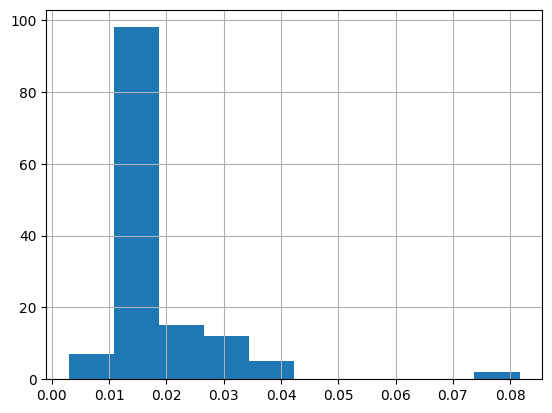

In [11]:
test['pred'] = rf.predict(X_test)
test['pred_prob'] = rf.predict_proba(X_test)[:,1]
test['pred_prob'].hist()

In [12]:
test['pred_prob'].describe()

count    139.000000
mean       0.018542
std        0.010021
min        0.002942
25%        0.014128
50%        0.015231
75%        0.018523
max        0.081640
Name: pred_prob, dtype: float64

In [13]:
test['pred_prob_quart'] = pd.qcut(test['pred_prob'], 4, labels=False)
test['pred_prob_quart'].value_counts()

pred_prob_quart
1    35
3    35
0    35
2    34
Name: count, dtype: int64

In [14]:
test.to_csv('../results/preds/preds_crc_ib_mut_act_rf_OS_comb_060623.csv')